In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    """Get the current stock price for a given ticker symbol."""
    return {
        "MSFT": 305.22,
        "AAPL": 174.55,
        "GOOGL": 134.76,
        "AMZN": 134.76,
        "TSLA": 305.22,
        "VED": 105.22,
        "META": 205.22
    }.get(symbol, 0.0)
    
tools = [get_stock_price]

In [5]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [6]:
def chatbot(state : State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot") # loop back to chatbot after using a tool      

graph = builder.compile()

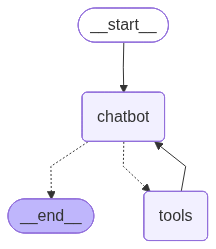

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]})
    return state["messages"][-1].content

call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?")

'OK. The current price for AMZN is $134.76 and for MSFT is $305.22.\n\nThe cost for 20 AMZN stocks is 20 * $134.76 = $2695.2\nThe cost for 15 MSFT stocks is 15 * $305.22 = $4578.3\n\nTherefore, the total cost would be $2695.2 + $4578.3 = $7273.5'